# Lets create a Recommendation system for the Henry coefficients of porous materials

In [169]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import scipy
import matplotlib

## We will use the Henry Coefficient matrix, created in `HenryMatrix.ipynb`

In [170]:
henry_df = pd.read_csv('data/henry_matrix_df_l.csv')
henry_df.set_index(list(henry_df)[0], inplace=True)
henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,XKRFYHLGVUSROY-UHFFFAOYSA-N_298K,OTMSDBZUPAUEDD-UHFFFAOYSA-N_298K,VGGSQFUCUMXWEO-UHFFFAOYSA-N_298K,QGZKDVFQNNGYKY-UHFFFAOYSA-N_298K,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,KFZMGEQAYNKOFK-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.819172,0.144939,0.320386,NaN,24.205548,37.271831,NaN,0.037489,NaN,NaN,...,NaN,2.465279,1.485443,NaN,NaN,NaN,NaN,NaN,NaN,70.666320
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,68.281549,0.539600,0.894258,0.118636,245.559959,98.475002,NaN,NaN,NaN,NaN,...,NaN,8.379069,5.183518,273.827233,238.268140,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,2.353366,0.327677,0.506284,0.206581,NaN,NaN,NaN,0.052552,11.828043,2.611847,...,NaN,4.054337,25.545118,1.473867,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1.745664,0.251414,0.775855,0.205777,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,497.528676,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,5.337171,0.312863,0.891286,0.325103,561.776898,156.994072,53.408676,0.044510,5.584650,NaN,...,0.290206,13.412198,53.218749,538.177243,266.241069,NaN,NaN,NaN,21520.194021,50.567251
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,5.390284,NaN,1.531122,NaN,NaN,NaN,30.263328,0.080570,2.688956,1.199634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.309893
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,1.566669,77.283640,0.433767,NaN,NaN,NaN,NaN,0.038820,0.915069,0.497998,...,0.194422,6.555848,NaN,93.599126,NaN,NaN,NaN,NaN,NaN,16.214376
NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f,2.537259,0.210701,0.594988,0.141437,NaN,NaN,NaN,7.123488,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-9ee35322ac5ddba224d845a03c651b29,338.978332,NaN,1.072150,NaN,NaN,NaN,NaN,0.029000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
idx = np.where(henry_df.values == 0)
idx

(array([], dtype=int64), array([], dtype=int64))

In [172]:
log_henry_df = henry_df.copy()
#log_henry_df.iat[idx[0][0], idx[1][0]] = np.nan
log_henry_df = np.log(log_henry_df)
log_henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,XKRFYHLGVUSROY-UHFFFAOYSA-N_298K,OTMSDBZUPAUEDD-UHFFFAOYSA-N_298K,VGGSQFUCUMXWEO-UHFFFAOYSA-N_298K,QGZKDVFQNNGYKY-UHFFFAOYSA-N_298K,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,KFZMGEQAYNKOFK-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,-0.199462,-1.931440,-1.138229,NaN,3.186582,3.618238,NaN,-3.283720,NaN,NaN,...,NaN,0.902305,0.395713,NaN,NaN,NaN,NaN,NaN,NaN,4.257969
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,4.223640,-0.616927,-0.111761,-2.131697,5.503541,4.589803,NaN,NaN,NaN,NaN,...,NaN,2.125737,1.645484,5.612497,5.473397,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,0.855847,-1.115727,-0.680658,-1.577064,NaN,NaN,NaN,-2.945943,2.470473,0.960058,...,NaN,1.399787,3.240446,0.387890,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,0.557135,-1.380655,-0.253790,-1.580963,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.209653,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1.674696,-1.161989,-0.115090,-1.123612,6.331105,5.056208,3.977973,-3.112048,1.720022,NaN,...,-1.237165,2.596165,3.974411,6.288188,5.584402,NaN,NaN,NaN,9.976747,3.923304
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,1.684598,NaN,0.426001,NaN,NaN,NaN,3.409937,-2.518626,0.989153,0.182016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.617897
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,0.448952,4.347482,-0.835249,NaN,NaN,NaN,NaN,-3.248815,-0.088756,-0.697158,...,-1.637723,1.880357,NaN,4.539021,NaN,NaN,NaN,NaN,NaN,2.785898
NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f,0.931084,-1.557317,-0.519213,-1.955904,NaN,NaN,NaN,1.963398,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-9ee35322ac5ddba224d845a03c651b29,5.825936,NaN,0.069666,NaN,NaN,NaN,NaN,-3.540443,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
#Creates a dictionary of InChIKeys to gas names (and gas names to InChIKeys)
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names (and material names to hashkeys)
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

## Lets also define a function that will randomly split our data into <i>k</i> folds

In [174]:
def k_fold_split(henry_df, k, max_iter=1000):
    assert k > 1, 'Choose a `k` greater than 1, otherwise this function is pointless'
    matrix = henry_df.values
    fold_matrix = np.full_like(matrix, -1, dtype=np.int)
    all_k_folds_not_represented_in_each_column = True
    n_iteration = 0
    while all_k_folds_not_represented_in_each_column:
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = False
        for i_row in range(matrix.shape[0]):
            # Grabs all available indices in row `i_row`
            j_indices = np.where(~np.isnan(matrix[i_row,:]))[0]
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while len(j_indices) >= k:
                for fold in range(k):
                    j = np.random.randint(0, len(j_indices))
                    fold_matrix[i_row, j_indices[j]] = fold
                    j_indices = np.delete(j_indices, j)
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for j in j_indices:
                fold_matrix[i_row, j] = np.random.randint(0, k)
        # We make sure we have enough data points in the columns as well
        for j_col in range(matrix.shape[1]):
            unique_folds = np.unique(fold_matrix[:, j_col])
            #print(len(vals[~np.isnan(vals)]))
            if len(unique_folds) <= k:
                all_k_folds_not_represented_in_each_column = True
                break
        # If too many iteration are performed an Exception is raised.
        if n_iteration > max_iter:
            raise Exception('Maximum number of iterations reached. Try changing the `max_iter` argument.')
    
    print('Number of iterations required to split data into {}-folds: {}'.format(k, n_iteration))
    return fold_matrix

fold_matrix = k_fold_split(henry_df, 3, max_iter=1e5)

Number of iterations required to split data into 3-folds: 13


In [175]:
def sort_matrix_by_freq(material_gas_matrix):
    row_sum = np.sum(material_gas_matrix, axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(material_gas_matrix[new_row_order, :], axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return material_gas_matrix[new_row_order, :][:, new_col_order]

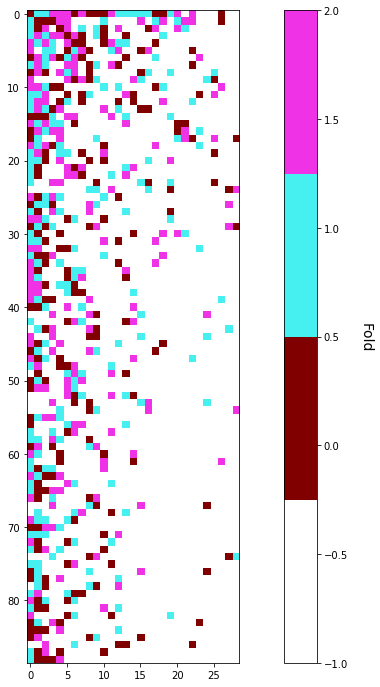

In [176]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
#my_cmap = matplotlib.cm.get_cmap('Accent')
mycmap = matplotlib.colors.ListedColormap(np.array([[255/255, 255/255, 255/255, 1], 
                                                    [128/255, 0, 0, 1], 
                                                    [70/255, 240/255, 240/255, 1], 
                                                    [240/255, 50/255, 230/255, 1],
                                                    [60/255, 180/255, 75/255, 1],
                                                    [245/255, 130/255, 48/255, 1]][:len(np.unique(fold_matrix))]))
plt.imshow(sort_matrix_by_freq(fold_matrix), interpolation='none', cmap=mycmap)
cbar = plt.colorbar()
cbar.set_label('Fold', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')

plt.show()

In [128]:
henry_df.mask(fold_matrix != 0).values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.50628371, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

### Lets start setting up the Recommender System algorithm

#### ALS methods implemented according to http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

In [177]:
def predict(m, g, mu):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + m.T.dot(g)

In [178]:
def predict_all(M, G, mu):
    predictions = np.zeros((M.shape[1], G.shape[1]))
    for m in range(M.shape[1]):
        for g in range(G.shape[1]):
            predictions[m, g] = predict(M[:,m], G[:,g], mu)
    return predictions

M shape: (5, 89)	G shape: (5, 29)
Train Error on iteration 0: 1.9990648183696662
-------------
Train Error on iteration 1000: 1.2230093629784116
-------------
Maximum number of iterations (1000) reached.


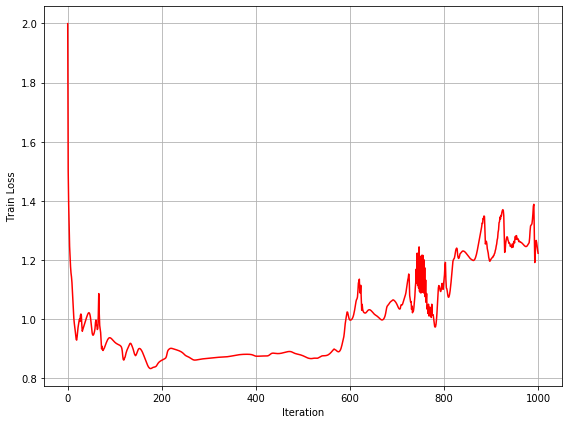

In [179]:
def ALS(henry_matrix, r, lambd, threshold, convergence=1e-6, maxiter=20000, verbose=True):
    assert len(lambd) == 2, "There should be two lambda values, one for each latent matrix"
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    convergence_cnt = 0
    
    M = np.random.rand(r+2, henry_matrix.shape[0])-0.5
    G = np.random.rand(r+2, henry_matrix.shape[1])-0.5
    M[-2,:] = 1.0
    G[-1,:] = 1.0
    if verbose:
        print('M shape: {}\tG shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        for m in range(M.shape[1]):
            mask = ~np.isnan(henry_matrix[m,:])
            b = (G[:,mask]).dot(henry_matrix[m,mask].T)
            A = G[:,mask].dot(G[:,mask].T) + lambd[0] * np.identity(r+2)
            M[:,m] = np.linalg.solve(A,b)
            M[-2,m] = 1.0
        for g in range(G.shape[1]):
            mask = ~np.isnan(henry_matrix[:,g])
            b = M[:,mask].dot(henry_matrix[mask,g])
            A = M[:,mask].dot(M[:,mask].T) + lambd[1] * np.identity(r+2)
            G[:,g] = np.linalg.solve(A,b)
            G[-1,g] = 1.0
            
        #pred = predict_all(M, G, 0.0)[~np.isnan(henry_matrix)]
        pred = M.T.dot(G)[~np.isnan(henry_matrix)]
        actual = henry_matrix[~np.isnan(henry_matrix)]
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual - pred)**2])/len(pred))
        train_error_arr.append(train_error)
        error_diff = np.abs(prev_error - train_error)
        if n % 1000 == 0:
            if verbose:
                print('Train Error on iteration {}: {}\n-------------'.format(n, train_error))
            
        if error_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 199:
                if verbose:
                    print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                    print('Train error: {}'.format(train_error))
                break
        else:
            convergence_cnt = 0
        n += 1
        if n > maxiter:
            print('Maximum number of iterations ({}) reached.'.format(maxiter))
            break
        if np.count_nonzero(np.isnan(M)) > 0 or np.count_nonzero(np.isnan(G)) > 0:
            raise Exception('NaN encountered in either latent representation')
    
    if verbose:
        fig, ax = plt.subplots(figsize=(8,6))
        #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Train Loss')
        plt.grid('on')
        plt.tight_layout()
        plt.show()
    
    return M, G, train_error_arr[-1]
a,b,c = ALS(log_henry_df.values, 3, [0.1, 0.2], 1e-5, maxiter=1000)

In [180]:
def cross_validation(henry_df, fold_matrix, r, lambd1, lambd2):
    k = len(np.unique(fold_matrix))-1
    print('-----------------------------------------\nStarting ALS with the following parameters:\nr = {}, lambda = [{:.2f}, {:.2f}]'.format(r, lambd1, lambd2))
    test_errors = []
    parity_pred = np.zeros(henry_df.shape)
    
    for test_fold in range(k):
        M, G, train_error = ALS(henry_df.mask(fold_matrix != test_fold).values, r, [lambd1, lambd2], 1e-4, 1e-5, 10000, False)
        pred = M.T.dot(G)[fold_matrix == test_fold]
        parity_pred[fold_matrix == test_fold] = pred
        pred = pred.flatten()
        actual = henry_df.values[fold_matrix == test_fold]
        test_errors.append(np.sqrt(np.sum([(actual - pred)**2])/len(actual)))
    test_error = np.mean(test_errors)
    print('Test Error: {:.3f}'.format(test_error))
    return test_error, parity_pred

_r = [5, 6]
_lambd1 = [2.0]
_lambd2 = [2.0]
fold_matrix = k_fold_split(log_henry_df, 3)
CV_dict = {}

for r in _r:
    for lambd1 in _lambd1:
        for lambd2 in _lambd2:
            test_error, parity_pred = cross_validation(log_henry_df, fold_matrix, r, lambd1, lambd2)
            cv_key = '{}_{}_{}'.format(r, lambd1, lambd2)
            CV_dict['{}_err'.format(cv_key)] = test_error
            CV_dict['{}_pred'.format(cv_key)] = parity_pred
            

Number of iterations required to split data into 3-folds: 6
-----------------------------------------
Starting ALS with the following parameters:
r = 5, lambda = [2.00, 2.00]
Maximum number of iterations (10000) reached.
Maximum number of iterations (10000) reached.
Maximum number of iterations (10000) reached.
Test Error: 0.608
-----------------------------------------
Starting ALS with the following parameters:
r = 6, lambda = [2.00, 2.00]
Test Error: 0.601


In [182]:
min_err = np.inf
min_key = "asdf"
for key in CV_dict:
    if type(CV_dict[key]) != np.float64:
        continue
    if CV_dict[key] < min_err:
        min_err = CV_dict[key]
        min_key = key
        
min_key

'6_2.0_2.0_err'

In [183]:
parity_pred = CV_dict['6_2.0_2.0_pred']

M shape: (8, 89)	G shape: (8, 29)
Train Error on iteration 0: 1.3626479261774411
-------------
Training has converged after 459 iterations. See `convergence` parameter for convergence procedure.
Train error: 0.5416522582620023


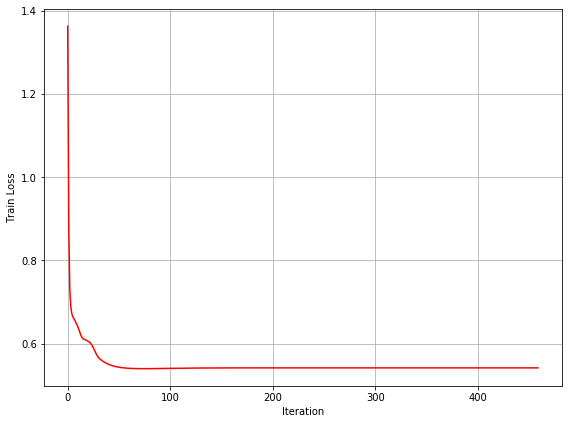

7282.213938060485

In [184]:
M, G, train_error = ALS(log_henry_df.values, 6, [2.0, 2.0], 1e-6, 1e-7, maxiter=50000, verbose=True)
#a,b,c = ALS(log_henry_df.values, 3, [0.1, 0.2], 1e-5, maxiter=1000)
h = np.exp(M.T.dot(G))
non_nan_mask = ~np.isnan(log_henry_df.values)
test_set = henry_df.values[non_nan_mask]
prediction = h[non_nan_mask]
test_error_from_recsys = np.sqrt(np.sum([(test_set - prediction)**2])/len(test_set))
test_error_from_recsys

In [185]:
means = np.nanmean(henry_df.values, axis=0)
prediction = np.zeros(henry_df.shape)
for (i, mean_i) in enumerate(means):
    prediction[:, i] = mean_i
prediction = prediction[non_nan_mask]
test_error_from_gas_avg = np.sqrt(np.sum([(test_set - prediction)**2])/np.sum(non_nan_mask))
test_error_from_gas_avg

10708.0817677893

In [186]:
means = np.nanmean(henry_df.values, axis=1)
prediction = np.zeros(henry_df.shape)
for (i, mean_i) in enumerate(means):
    prediction[i, :] = mean_i
prediction = prediction[non_nan_mask]
test_error_from_mof_avg = np.sqrt(np.sum([(test_set - prediction)**2])/np.sum(non_nan_mask))
test_error_from_mof_avg

11358.56515429765

In [187]:
def sort_df_by_freq(df):
    row_sum = np.sum(~np.isnan(df.values), axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(~np.isnan(df.values[new_row_order, :]), axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return new_row_order, new_col_order
new_row_order, new_col_order = sort_df_by_freq(log_henry_df)

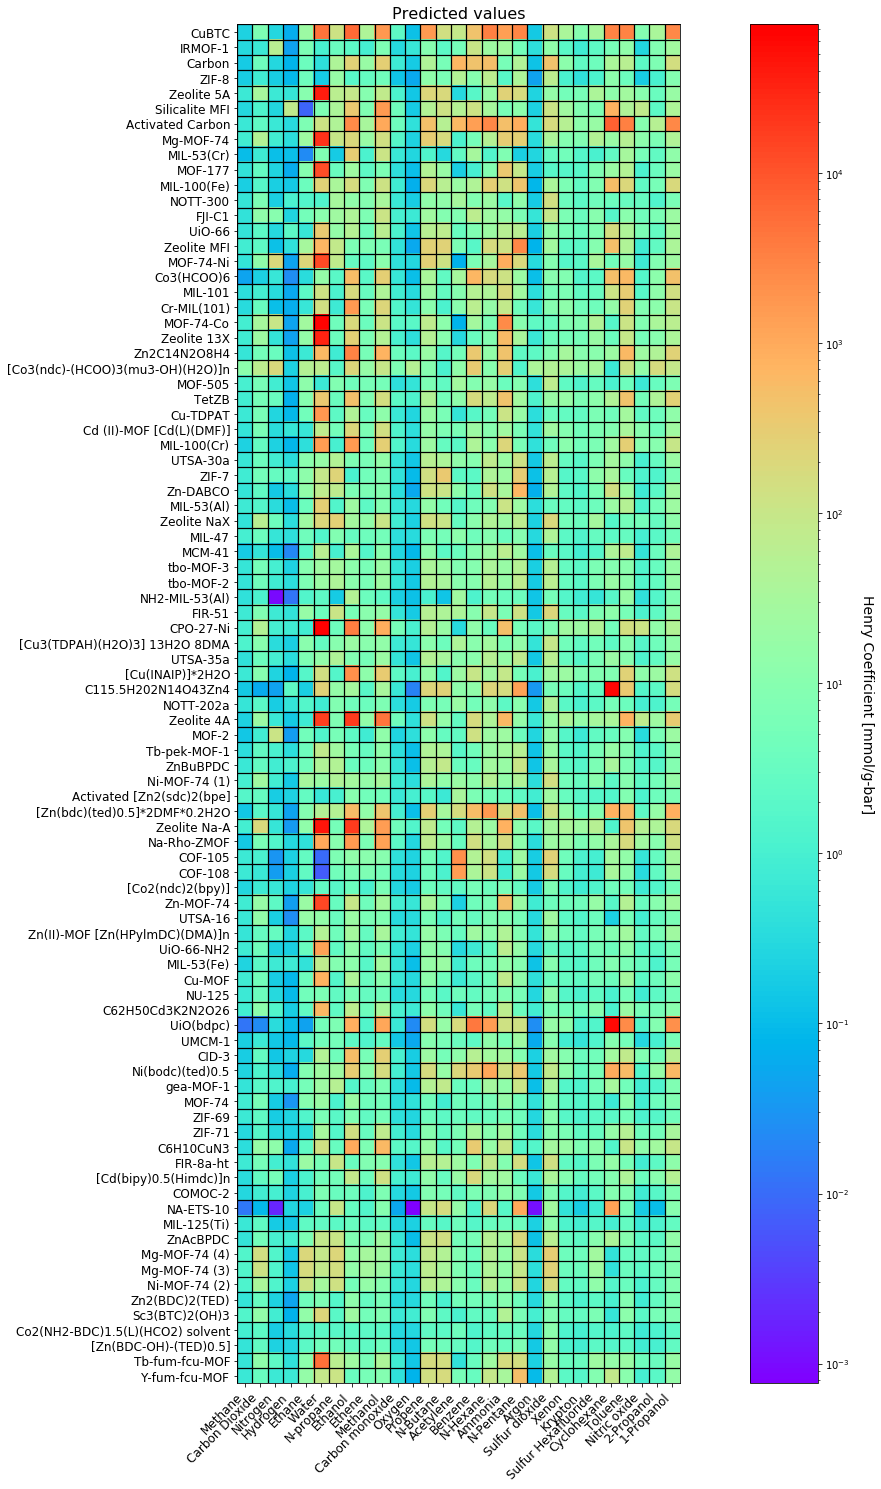

In [188]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()
temp_h = np.copy(h)
temp_h[temp_h < 1e-4] = 1e-4
for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(h[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(h.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(h.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)
plt.title('Predicted values', fontsize=16)

plt.show()

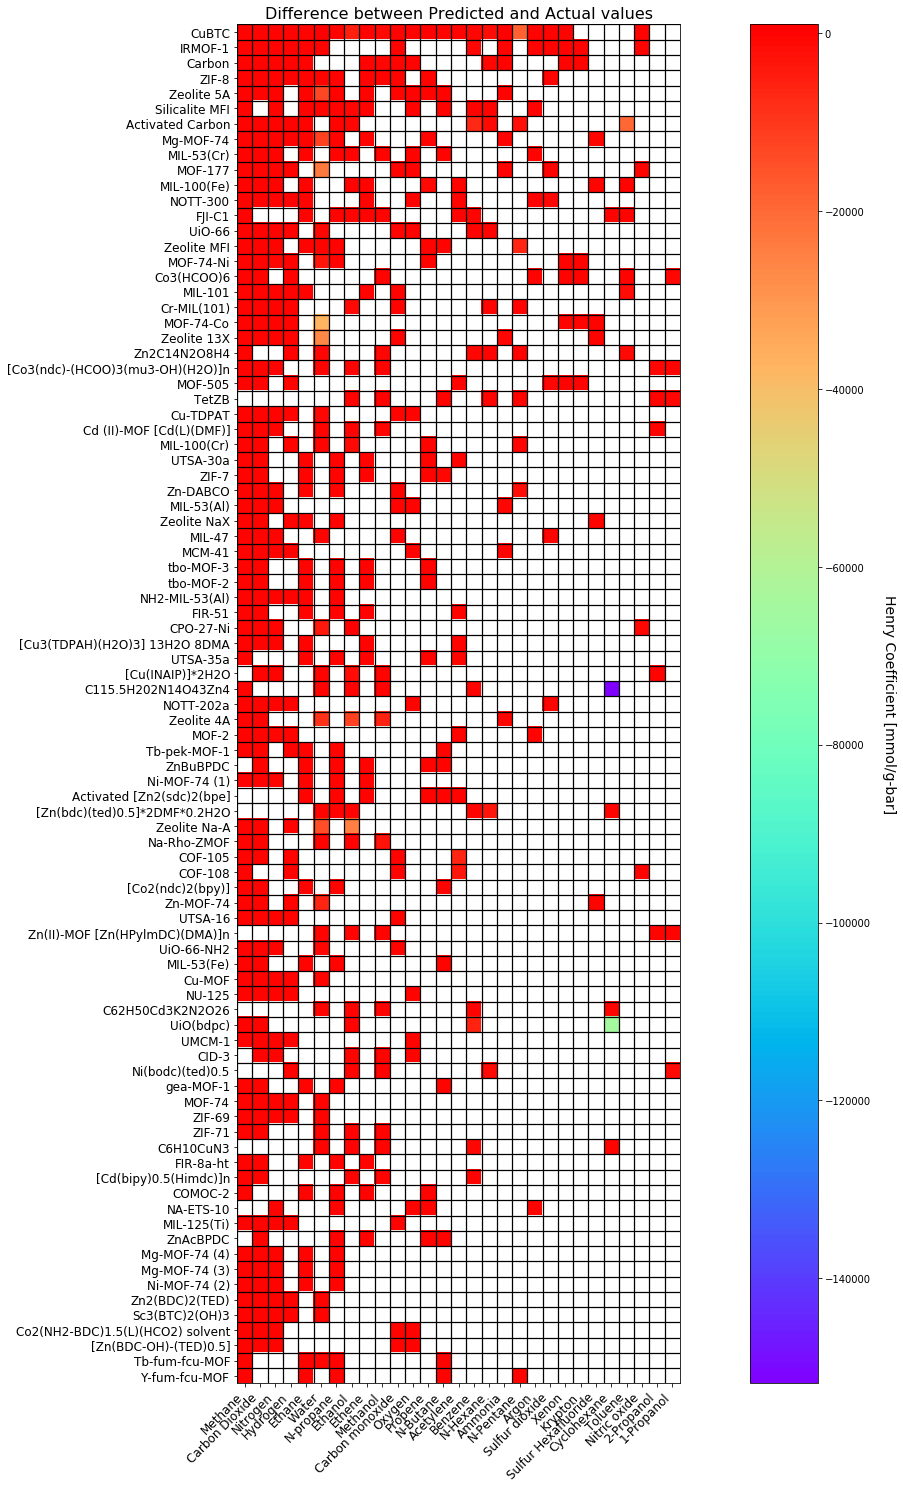

In [189]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()
h_diff = h - henry_df.values

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(h_diff[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(h.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(h.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)
plt.title('Difference between Predicted and Actual values', fontsize=16)

plt.show()

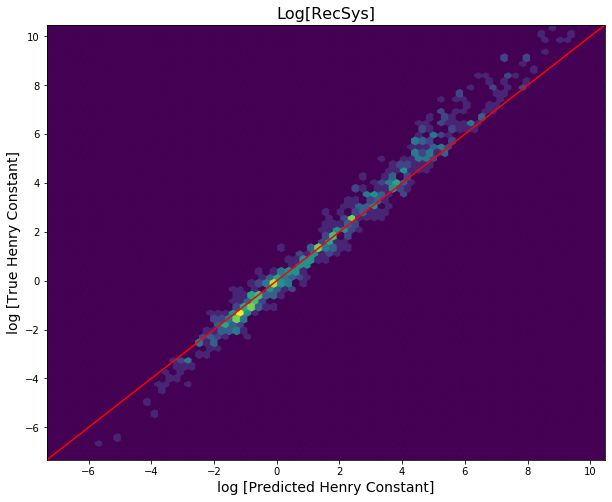

In [190]:
def parity_plot(actual, parity_pred, title):
    fig, ax = plt.subplots(figsize=(10,8))
    
    prediction = parity_pred.flatten()
    actual = actual.values.flatten()
    mask = ~np.isnan(actual)
    
    ax.hexbin(prediction[mask], actual[mask], gridsize=75)
    #ax.scatter(prediction[mask], actual[mask])
    
    lim = [np.max([np.min(actual[mask]), np.min(parity_pred)]), np.min([np.max(actual[mask]), np.max(parity_pred)])]
    
    ax.plot(lim, lim, c='r')
    ax.set_xlabel('log [Predicted Henry Constant]', fontsize=14)
    ax.set_ylabel('log [True Henry Constant]', fontsize=14)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    #ax2 = fig.add_axes([0.175, 0.625, 0.25, 0.25])
    
    #ax2.hexbin(prediction[mask], actual[mask], gridsize=50)
    #ax2.plot(lim, lim, c='r', alpha=0.5)
    #ax2.set_xlim([-5, 5])
    #ax2.set_ylim([-5, 5])
    ax.set_title(title, fontsize=16)
    
    plt.show()
    
parity_plot(log_henry_df, parity_pred, 'Log[RecSys]')

In [191]:
test_set = henry_df.values.flatten()
non_nan_mask = ~np.isnan(test_set)
prediction = h.flatten()
test_error_from_recsys = np.sqrt(np.sum([(test_set[i] - prediction[i])**2 for i in np.arange(len(prediction))[non_nan_mask]])/len(prediction[non_nan_mask]))
test_mean = np.nanmean(test_set)

R_squared = 1 - np.sum([(test_set[i] - prediction[i])**2 for i in np.arange(len(prediction))[non_nan_mask]]) / np.sum([(test_set[i] - test_mean)**2 for i in np.arange(len(prediction))[non_nan_mask]])
print('R_squared = {:.3f}'.format(R_squared))

R_squared = 0.659


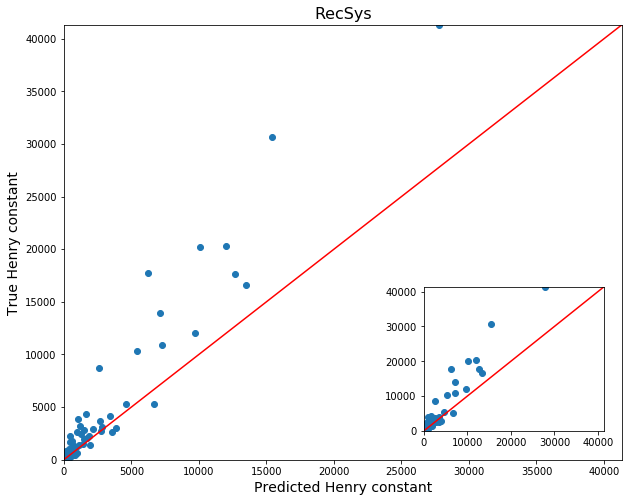

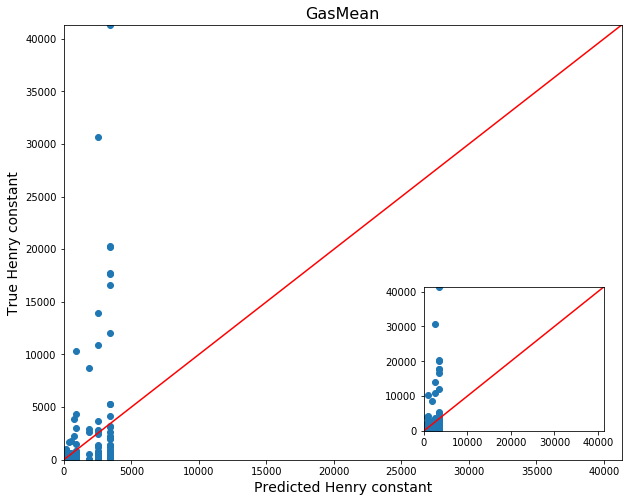

In [168]:
def parity_plot_real(actual, prediction, title):
    fig, ax = plt.subplots(figsize=(10,8))
    
    prediction = prediction.flatten()
    actual = actual.values.flatten()
    mask = ~np.isnan(actual)
    
    ax.scatter(prediction[mask], actual[mask])
    lim = [np.min([np.min(actual[mask]), np.min(parity_pred)]), np.max([np.max(actual[mask]), np.max(parity_pred)])]

    ax.plot(lim, lim, c='r')
    ax.set_xlabel('Predicted Henry constant', fontsize=14)
    ax.set_ylabel('True Henry constant', fontsize=14)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    
    ax2 = fig.add_axes([0.625, 0.175, 0.25, 0.25])
    ax2.scatter(prediction[mask], actual[mask])
    ax2.set_xlim(lim)
    ax2.set_ylim(lim)
    ax2.plot(lim, lim, c='r')
    ax.set_title(title, fontsize=16)
    plt.show()
    
parity_plot_real(henry_df, h, 'RecSys')
means = np.nanmean(henry_df.values, axis=0)
prediction = np.zeros(henry_df.shape)
for (i, mean_i) in enumerate(means):
    prediction[:, i] = mean_i

parity_plot_real(henry_df, prediction, 'GasMean')

# Trashbin

In [ ]:
def predict_v3(x, y, mu):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + (x.T).dot(y)

In [ ]:
def predict_all_v3(U, V, mu):
    predictions = np.zeros((U.shape[0], V.shape[1]))
    for u in range(U.shape[0]):
        for i in range(V.shape[1]):
            predictions[u, i] = predict_v3(U[u,:], V[:,i], mu)
    return predictions

In [ ]:
def WNMF(henry_matrix, r, threshold, convergence=1e-5, maxiter=100000, verbose=True):
    n_iter = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    n_convergence = 0
    n, m = henry_matrix.shape
    
    W = ~np.isnan(henry_matrix)
    U = np.random.rand(n, r)
    V = np.random.rand(r, m)
    WA = np.multiply(W, henry_matrix)
    WA[np.isnan(WA)] = 0.0

    print('U shape: {}\tV shape: {}'.format(U.shape, V.shape))
    while train_error > threshold:
        
        for j in range(r):
            # Move WUV #1 here?
            WUV = np.multiply(W, np.matmul(U,V))
            for i in range(n):
                #WUV = np.multiply(W, np.matmul(U,V))
                U[i,j] = U[i,j] * (np.matmul(WA, np.transpose(V)))[i,j] / (np.matmul(WUV, np.transpose(V)))[i,j]
            # Move WUV #2 here?
            WUV = np.multiply(W, np.matmul(U,V))
            for i in range(m):
                #WUV = np.multiply(W, np.matmul(U,V))
                V[j,i] = V[j,i] * (np.matmul(np.transpose(U), WA))[j,i] / (np.matmul(np.transpose(U), WUV))[j,i] 
            
            if any(np.isnan(U.flatten())):
                raise Exception('''nan's in U''')
            if any(np.isnan(V.flatten())):
                raise Exception('''nan's in V''')
        
        pred = predict_all_v3(U, V, 0.0)[W].flatten()
        actual = henry_matrix[W].flatten()
        
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n_iter % 1000 == 0:
            print('Train Error on iteration {}: {}\n-------------'.format(n_iter, train_error))
            
        if error_diff < convergence:
            n_convergence += 1
            if n_convergence > 999:
                print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n_iter))
                print('Train error: {}'.format(train_error))
                break
        else:
            n_convergence = 0
        n_iter += 1
        if n_iter > maxiter:
            print('Maximum number of iterations reached.')
            break
    
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Train Loss')
    plt.grid('on')
    plt.tight_layout()
    plt.show()
    
    return U, V
mu = np.nanmean(henry_df.values)
norm_factors = np.nanmean(henry_df.values, axis=0)

U2, V2 = WNMF(henry_df.values/norm_factors, 20, 1e-5)

In [ ]:
h = np.matmul(U2,V2) * norm_factors
#i = random.choice(np.arange(henry_df.shape[0]))
#j = random.choice(np.arange(henry_df.shape[1]))
_i,_j = np.where(np.isnan(henry_df.values))
for _ in range(10):
    idx = random.choice(np.arange(len(_i)))
    i = _i[idx]
    j = _j[idx]
    print('Adsorption of {} in {}'.format(key_to_gas[henry_df.columns[j].split('_')[0]], key_to_material[henry_df.index[i]]))
    print('Prediction: {:.3f}'.format(h[i,j]))
    print('Actual value: {:.3f}\n'.format(henry_df.values[i,j]))

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
n = 8
ax.scatter(U2[:n, 0], U2[:n, 1], color='red', marker='x')
ax.scatter(V2[0,:n], V2[1,:n], color='blue', marker='o')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')

for i in range(n):
    ax.text(U2[i,0], U2[i,1], key_to_gas[henry_df.columns[i].split('_')[0]])
    ax.text(V2[0,i], V2[1,i], key_to_material[henry_df.index[i]])
plt.show()

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1, color='k')

plt.imshow(henry_df.values[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(henry_df.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(henry_df.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(h[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(h.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(h.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,8))
axs[0].hist(henry_df.values[~np.isnan(henry_df)].flatten(), bins=50)
axs[0].set_xlabel('Actual Henry constant [mmol/(g-bar)]')
axs[0].set_ylabel('Frequency')

axs[1].hist(h.flatten(), bins=50)
axs[1].set_xlabel('Predicted Henry constant [mmol/(g-bar)]')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
max_ind = np.unravel_index(np.argmax(h, axis=None), h.shape)

gas = key_to_gas[henry_df.columns[max_ind[1]].split('_')[0]]
material = key_to_material[henry_df.index[max_ind[0]]]
print('Biggest prediction is {:.2f} mmol/(g-bar)\nGas: {}, Material: {}'.format(h[max_ind], gas, material))
